In [1]:
# This cell installs the GPU version of LightGBM
! git clone --recursive https://github.com/Microsoft/LightGBM

%cd /content/LightGBM
! mkdir -p build

%cd build
! cmake -DUSE_GPU=1 /content/LightGBM
! make -j$(nproc)
! sudo apt-get -y install python-pip
! sudo -H pip install setuptools numpy scipy scikit-learn -U

%cd /content/LightGBM/python-package
! sudo python setup.py install --precompile

%cd /content/

fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM
/content/LightGBM/build
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM/build
[  2%] Built target lightgbm_capi_objs
[ 89%] Built target lightgbm_objs
[ 97%] Built target lightgbm
[100%] Built target _lightgbm
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/content/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  s

In [2]:
!pip install catboost gdown

In [3]:
#* Download dataset
!gdown --id 1-6TLVgf4ksqyaSkodFMtnJdsDcc86A_6

Downloading...
From: https://drive.google.com/uc?id=1-6TLVgf4ksqyaSkodFMtnJdsDcc86A_6
To: /content/used_cars_data.csv
100% 9.98G/9.98G [01:38<00:00, 102MB/s] 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

In [6]:
from typing import List
from tqdm import tqdm
import warnings
import pickle
import gc

In [7]:
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

In [8]:
class DataModeler:
    def __init__(self):
        pass

    def _parametrized(dec):
        def layer(*args, **kwargs):
            def repl(f):
                return dec(f, *args, **kwargs)
            return repl
        return layer

    @staticmethod
    @_parametrized
    def logger(f, job):
        def aux(self, *xs, **kws):
            print("="*50)
            print(job + "...")
            res = f(self, *xs, **kws)
            print(job + " is done")
            print("="*50)
            return res
        return aux

In [9]:
class DataPreprocessor(DataModeler):
    "Wrap the operations of data preprocessing."
    
    def __init__(self):
        super(DataPreprocessor, self).__init__()
        self.label_encoder_dict = {}

    @staticmethod
    def create_folds(data:pd.DataFrame, num_splits:int) -> pd.DataFrame:
        """
        Use stratified kfold to split data according to target distribution.
        @param data: datafram
        @param num_splits: number of splits
        return: splitted data, use a new column named 'fold' to separate
        """
        data["fold"] = -1
        num_bins = int(np.floor(1 + np.log2(len(data))))
        data.loc[:, "bins"] = pd.cut(data["price"], bins=num_bins, labels=False)
        kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=2022)
        
        for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
            data.loc[v_, 'fold'] = f
        
        data = data.drop("bins", axis=1)

        return data

    #* =======================================================================================
    @DataModeler.logger("Dropping useless data")
    def _drop_data(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Drop rows and columns
        @param df: Dataframe
        return: Processed dataframe
        """
        #* Drop rows with duplicate vin
        df = df.groupby('vin', as_index=False).first()        
        #* Drop rows with VIN length not equal to 17
        df = df[df['vin'].str.len()==17]             
        #* Drop rows with duplicate listing_id 
        df = df.groupby('listing_id', as_index=False).first()

        #* Drop invalid columns
        cols_to_drop = [
            'vehicle_damage_category', 'combine_fuel_economy', 'is_certified', 'bed', 'cabin',
            'is_oemcpo', 'is_cpo', 'bed_length', 'bed_height', 'engine_type', 
            'wheel_system_display', 'trim_name', 'trimId', 'sp_id', 'sp_name',
            'latitude', 'longitude', 'city', 'dealer_zip', 'daysonmarket', 'listed_date',
            'main_picture_url', 'savings_amount', 'franchise_dealer', 'seller_rating', 'franchise_make',
            'description', 'major_options', 'listing_id', 'interior_color', 'exterior_color'
        ]
        df.drop(columns=cols_to_drop, inplace=True)

        return df
    
    #* =======================================================================================
    @DataModeler.logger("Cleaning data")
    def _clean_data(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Clean data
        @param df: Dataframe
        return: cleaned dataframe
        """
        df = df[pd.array(df['price'] < 1e5)]
        df = df[~df['mileage'].isna()]

        dic_trans_dis = {"Automatic": "6", "Continuously Variable Transmission": "6", "Manual": "6"}
        df["transmission_display"].replace(dic_trans_dis, inplace=True)

        dic_engine = {"I4 Hybrid": "I4", "I4 Diesel": "I4", "I4 Flex Fuel Vehicle": "I4", "V6 Hybrid": "V6", "V6 Biodiesel": "V6" ,
              "V6 Flex Fuel Vehicle": "V6", "V8 Flex Fuel Vehicle": "V8", "I6 Diesel": "I6", "I6 Biodiesel": "I6", "V6 Diesel": "V6", 
              "H4 Hybrid": "H4", "W12 Flex Fuel Vehicle": "W12", "V8 Hybrid": "V8", "I4 Compressed Natural Gas": "I4", "I6 Hybrid": "I6",
              "V6 Compressed Natural Gas": "V6", "V8 Biodiesel": "V8", "V8 Diesel": "V8", "I5 Biodiesel": "I5", "V8 Compressed Natural Gas": "V8",
              "I5 Diesel": "I5", "V8 Propane": "V8", "I3 Hybrid": "I3", "V10 Diesel": "V10", "V12 Hybrid": "V12"}
        df["engine_cylinders"].replace(dic_engine, inplace=True)
        dic_engine_type = {"I2": "Inline 2 cylinder", "I3": "Inline 3 cylinder", "I4": "Inline 4 cylinder", 
                   "I5": "Inline 5 cylinder", "I6": "Inline 6 cylinder", "R2": "Rotary Engine", "Electric_Motor": "Electric Motor",
                   "H4": "Boxer 4 cylinder", "H6": "Boxer 6 cylinder"}
        df["engine_cylinders"].replace(dic_engine_type, inplace=True)

        dic_transmission = {"A": "Automatic Transmission (A)", "CVT": "Continuously Variable Transmission (CVT)", 
                    "Dual Clutch": "Dual Clutch Transmission (DCT)", "M": "Manual Transmission (M)"}
        df["transmission"].replace(dic_transmission, inplace=True)

        dic_wheel_system = {"FWD": "Front Wheel Drive (FWD)", "AWD": "All Wheel Drive (AWD)", "4WD": "Four Wheel Drive (4WD)", "RWD": "Rear Wheel Drive (RWD)",
                    "4X2": "Two Wheel Drive (4X2)"}
        df["wheel_system"].replace(dic_wheel_system, inplace=True)

        return df
    
    #* =======================================================================================
    def __trans_feat_type(self, df:pd.DataFrame, cols:List[str], unit:str) -> pd.DataFrame:
        """
        Transform str type cols in df into specified data type.
        Treat '--' as nan.
        @param df: Dataframe
        @params cols: Columns to be transformed
        @param unit: Unit of measurement, needed to be cropped from the original data
        return: Processed dataframe
        """
        for col in cols:
            mask = df[col].str.contains("--") | df[col].isna() #* nan rows
            df[col][mask] = np.nan                             #* replace '--' as nan
            df[col][~mask] = df[col][~mask].str.replace(" "+unit, "")
            df[col] = df[col].astype(float)
        
        return df

    @DataModeler.logger("Transforming feature type")
    def _trans_feat_type(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Transform feature dtype.
        @param df: Dataframe
        return: Processed dataframe
        """
        df = self.__trans_feat_type(df, ['width', 'wheelbase', 'length', 'height', 'front_legroom', 'back_legroom'], "in")
        df = self.__trans_feat_type(df, ['maximum_seating'], "seats")
        df = self.__trans_feat_type(df, ['fuel_tank_volume'], "gal")

        df['torque'] = df['torque'].astype(str)
        df['torque'][~df['torque'].str.contains('RPM')] = np.nan #* there is a row with value '174 lb-ft', replace it as nan
        df['torque_power'] = np.nan
        df['torque_power'][~df['torque'].isna()] = df['torque'][~df['torque'].isna()].apply(lambda x:x.split('@')[0][:-6].replace(',',''))
        df['torque_power'] = df['torque_power'].astype(float)
        df['torque_rpm'] = np.nan
        df['torque_rpm'][~df['torque'].isna()] = df['torque'][~df['torque'].isna()].apply(lambda x:x.split('@')[1][:-3].replace(',',''))
        df['torque_rpm'] = df['torque_rpm'].astype(float)
        del df['torque']

        df['power'] = df['power'].astype(str)
        df['power'][~df['power'].str.contains('RPM')] = np.nan
        df['power_rpm'] = np.nan
        df['power_rpm'][~df['power'].isna()] = df['power'][~df['power'].isna()].apply(lambda x:x.split('@')[1][:-3].replace(',',''))
        df['power_rpm'] = df['power_rpm'].astype(float)
        del df['power']

        df['transmission_display'] = df["transmission_display"].str.extract('(\d+)', expand=False).astype("float16")

        return df
  
    #* =======================================================================================
    def __impute_with_mean(self, df:pd.DataFrame, col:str, groupby_cols:List[str]) -> pd.DataFrame:
        """
        Impute categorical feature with mean.
        @param df: Dataframe
        @param col: Target column
        @param groupby_cols: Columns used for groupby
        return: Imputed dataframe
        """
        df["avg_"+col] = df.groupby(groupby_cols)[col].transform("mean")
        df[col] = np.where(df[col].isna(), df["avg_"+col], df[col])
        del df["avg_"+col]

        return df

    def __impute_with_mode(self, df:pd.DataFrame, col:str, groupby_cols:List[str]) -> pd.DataFrame:
        """
        Impute categorical feature with mode.
        @param df: Dataframe
        @param col: Target column
        @param groupby_cols: Columns used for groupby
        return: Imputed dataframe
        """
        tmp = df.groupby(groupby_cols)[col].apply(lambda x: x.mode()).to_frame(name="mode").reset_index()
        tmp = tmp.drop(["level_2"], axis=1)
        df = df.merge(tmp, on=groupby_cols)
        df[col] = np.where(df[col].isna(), df['mode'], df[col])
        del df['mode']
        del tmp

        return df

    @DataModeler.logger("Imputing data")
    def _impute_data(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Impute nan values
        @param df: Dataframe
        return: Imputed dataframe
        """
        cols = ['back_legroom']
        for col in cols:
            df[col] = df[col].fillna(df[col].mean())
        
        df.loc[df["fuel_type"] == "Electric", "engine_cylinders"] = "Electric_Motor"
        df.loc[df["fuel_type"] == "Electric", "transmission_display"] = 6
        df.loc[df["fuel_type"] == "Electric", "fuel_tank_volume"] = df.fuel_tank_volume.mean()

        df['owner_count'] = df['owner_count'].fillna(1)

        #* Use mode to impute categorical feats
        df = self.__impute_with_mode(df, 'body_type', ['make_name','model_name'])
        df = self.__impute_with_mode(df, 'transmission', ['make_name','model_name'])
        df = self.__impute_with_mode(df, 'fuel_type', ['make_name','model_name'])
        df = self.__impute_with_mode(df, 'engine_cylinders', ['make_name','model_name'])
        df = self.__impute_with_mode(df, 'wheel_system', ['make_name','model_name'])

        #* Use mean to impute numerical feats
        df = self.__impute_with_mean(df, 'maximum_seating', ["make_name", "model_name", "body_type"])
        df = self.__impute_with_mean(df, 'horsepower', ["engine_cylinders", "fuel_type", "make_name", "model_name",  "year"])
        df = self.__impute_with_mean(df, 'engine_displacement', ["engine_cylinders", "fuel_type", "make_name", "model_name",  "year"])
        df = self.__impute_with_mean(df, 'city_fuel_economy', ["body_type", "engine_displacement", "engine_cylinders", "fuel_type", 
                                                                "horsepower", "make_name", "model_name",  "year"])
        df = self.__impute_with_mean(df, 'highway_fuel_economy', ["body_type", "engine_displacement", "engine_cylinders", "fuel_type", 
                                                                "horsepower", "make_name", "model_name",  "year"])
        df = self.__impute_with_mean(df, 'torque_power', ["engine_cylinders", "engine_displacement", "horsepower", "fuel_type", "make_name"])
        df = self.__impute_with_mean(df, 'torque_rpm', ["engine_cylinders", "engine_displacement", "horsepower", "fuel_type", "make_name"])
        df = self.__impute_with_mean(df, 'power_rpm', ["engine_cylinders", "engine_displacement", "horsepower", "fuel_type", "make_name"])
        df = self.__impute_with_mean(df, 'fuel_tank_volume', ["make_name", "model_name",  "year"])


        df['fleet'] = df['fleet'].fillna('Unkown').astype(str)
        df['frame_damaged'] = df['frame_damaged'].fillna('Unkown').astype(str)
        df['has_accidents'] = df['has_accidents'].fillna('Unkown').astype(str)
        df['isCab'] = df['isCab'].fillna('Unkown').astype(str)
        df['salvage'] = df['salvage'].fillna('Unkown').astype(str)
        df['theft_title'] = df['theft_title'].fillna('Unkown').astype(str)

        return df

    #* =======================================================================================
    @DataModeler.logger("Reducing memory usage")
    def _reduce_mem_usage(self, df:pd.DataFrame):
        """
        Rudce memory usage by changing feature dtype.
        Credit to https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
        """
        start_mem_usg = df.memory_usage().sum() / 1024**2 
        print("Memory usage of dataframe is :",start_mem_usg," MB")
        NAlist = [] # Keeps track of columns that have missing values filled in. 
        for col in df.columns:
            if df[col].dtype != object:  # Exclude strings
                
                # Print current column type
                print("******************************")
                print("Column: ",col)
                print("dtype before: ",df[col].dtype)
                
                # make variables for Int, max and min
                IsInt = False
                mx = df[col].max()
                mn = df[col].min()
                
                # integer does not support NA, therefore, NA needs to be filled
                if not np.isfinite(df[col]).all(): 
                    NAlist.append(col)
                    df[col].fillna(mn-1,inplace=True)  
                    
                # test if column can be converted to an integer
                asint = df[col].fillna(0).astype(np.int64)
                result = (df[col] - asint)
                result = result.sum()
                if result > -0.01 and result < 0.01:
                    IsInt = True

                
                # Make Integer/unsigned Integer datatypes
                if IsInt:
                    if mn >= 0:
                        if mx < 255:
                            df[col] = df[col].astype(np.uint8)
                        elif mx < 65535:
                            df[col] = df[col].astype(np.uint16)
                        elif mx < 4294967295:
                            df[col] = df[col].astype(np.uint32)
                        else:
                            df[col] = df[col].astype(np.uint64)
                    else:
                        if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                            df[col] = df[col].astype(np.int8)
                        elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                            df[col] = df[col].astype(np.int16)
                        elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                            df[col] = df[col].astype(np.int32)
                        elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                            df[col] = df[col].astype(np.int64)    
                
                # Make float datatypes 32 bit
                else:
                    df[col] = df[col].astype(np.float32)
                
                # Print new column type
                print("dtype after: ",df[col].dtype)
                print("******************************")
        
        # Print final result
        print("___MEMORY USAGE AFTER COMPLETION:___")
        mem_usg = df.memory_usage().sum() / 1024**2 
        print("Memory usage is: ",mem_usg," MB")
        print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
        return df, NAlist

    #* =======================================================================================
    @DataModeler.logger("Label encoding features")
    def label_encode(self, df:pd.DataFrame, cols:List[str]) -> pd.DataFrame:
        """
        Label encode specified columns so they can be fed into the Lightgbm model
        @param df: Datafram
        @param cols: Categorical feature names
        return: Transformed dataframe
        """
        for col in cols:
            if col not in self.label_encoder_dict.keys():
                label_encoder = LabelEncoder()
            else:
                label_encoder = self.label_encoder_dict[col]
            
            df[col] = label_encoder.fit_transform(df[col])
            df[col] = df[col].astype('int')
            self.label_encoder_dict[col] = label_encoder

        return df
    
    @staticmethod
    def onehot_encode(df:pd.DataFrame, cols:List[str]) -> pd.DataFrame:
        """
        One-hot encode specified columns so they can be fed into normal models
        @param df: Datafram
        @param cols: Categorical feature names
        return: Transformed dataframe
        """
        for col in cols:
            res = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df,res],axis=1)

        return df
    
    #* =======================================================================================
    def preprocess(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess original data.
        @param df: original data
        return: preprocessed data
        """
        df = self._drop_data(df)
        df = self._clean_data(df)
        df = self._trans_feat_type(df)
        df = self._impute_data(df)

        former_len = df.shape[0]
        df = df.dropna()
        curr_len = df.shape[0]
        print(f"{former_len-curr_len} rows with na are dropped")

        df, _ = self._reduce_mem_usage(df)

        df = df.reset_index(drop=True)
        return df

In [10]:
class FeatureEngineer(DataModeler):
    "Wrap the operations of feature engineering."
    
    def __init__(self):
        super(FeatureEngineer, self).__init__()
    
    def _groupby_feats(self, df:pd.DataFrame, col:str, groupby_cols:List[str], method:str) -> pd.DataFrame:
        """
        Generate groupby features
        @param df: Dataframe
        @param col: target column
        @param groupby_cols: Columns used to groupby
        @param method: aggregate method, e.g. 'mean'
        """
        df_tmp = df[groupby_cols+[col]]
        df_tmp = df_tmp.groupby(groupby_cols, as_index=False)[col].agg([method]).reset_index()
        df_tmp = df_tmp.rename(columns={method: '_'.join(groupby_cols)+'__'+ col +'__'+method})
        df = pd.merge(df, df_tmp, on=groupby_cols, how='left')

        return df
    
    def _target_encode(self, df:pd.DataFrame, groupby_cols:List[str], method:str) -> pd.DataFrame:
        """
        Target encode categorical features
        @param df: Dataframe
        @param groupby_cols: Columns used to groupby
        @param method: aggregate method, e.g. 'mean'
        """
        df_tmp = df[df['is_train']==1][groupby_cols+['price']]
        df_tmp = df_tmp.groupby(groupby_cols,as_index=False)['price'].agg([method]).reset_index()
        df_tmp = df_tmp.rename(columns={method: '_'.join(groupby_cols)+'__price__'+method})
        df = pd.merge(df, df_tmp, on=groupby_cols, how='left')

        return df

    def generate_feats(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Generate new features.
        @param df: dataframe
        return: dataframe with new features
        """
        df = self._groupby_feats(df, 'mileage', ["make_name", "model_name",  "year"], 'mean')
        df = self._groupby_feats(df, 'mileage', ["make_name", "model_name",  "year", "engine_cylinders", "fuel_type"], 'mean')
        df = self._groupby_feats(df, 'mileage', ['make_name','model_name'], 'std')
        df = self._groupby_feats(df, 'mileage', ["make_name", "model_name",  "year", "engine_cylinders", "fuel_type"], 'std')
        df = self._groupby_feats(df, 'mileage', ["make_name", "engine_cylinders", "engine_displacement", "horsepower", "fuel_type"], 'mean')
        df = self._groupby_feats(df, 'mileage', ["make_name", "model_name",  "year", "body_type", "engine_cylinders", "engine_displacement", "horsepower", "fuel_type"], 'mean')

        df = self._groupby_feats(df, 'mileage', ["make_name", "model_name",  "year"], 'count')
        df = self._groupby_feats(df, 'mileage', ["make_name", "model_name",  "year", "engine_cylinders", "fuel_type"], 'count')
        df = self._groupby_feats(df, 'mileage', ["make_name", "engine_cylinders", "engine_displacement", "horsepower", "fuel_type"], 'count')
        df = self._groupby_feats(df, 'mileage', ["make_name", "model_name",  "year", "body_type", "engine_cylinders", "engine_displacement", "horsepower", "fuel_type"], 'count')
        
        df = self._target_encode(df, ['make_name','model_name'], 'mean')
        df = self._target_encode(df, ["make_name", "model_name",  "year"], 'mean')

        cat_feats = ['body_type', 'engine_cylinders', 'fleet', 'frame_damaged', 'fuel_type',
        'has_accidents', 'isCab', 'listing_color', 'make_name', 'model_name',
        'salvage', 'theft_title', 'transmission', 'wheel_system']
        for f in cat_feats:
            df = self._target_encode(df, [f], 'mean')
            df = self._groupby_feats(df, 'mileage', [f], 'mean')
        
        df['mile_per_year'] = df['mileage'] / (2022 - df['year'])
        df['city_fuel_spent'] = df['mileage'] * df['city_fuel_economy']
        df['highway_fuel_spent'] = df['mileage'] * df['highway_fuel_economy']


        return df

In [11]:
class Learner(DataModeler):
    def __init__(self):
        super(Learner, self).__init__()

        self.model_dict = {
            'LR':    {'class':LinearRegression,      'model':[]},
            'Ridge': {'class':Ridge,                 'model':[]},
            'Lasso': {'class':Lasso,                 'model':[]},
            'DT':    {'class':DecisionTreeRegressor, 'model':[]},
            'KNN':   {'class':KNeighborsRegressor,   'model':[]},
            'RF':    {'class':RandomForestRegressor, 'model':[]},
            'SVM':   {'class':SVR,                   'model':[]},
            'LGB':   {'class':None,                  'model':[]},
            'XGB':   {'class':None,                  'model':[]},
            'CAT':   {'class':None,                  'model':[]}
        }
    
    def _lgb_train(self, train_x:pd.DataFrame, train_y:pd.DataFrame, valid_x:pd.DataFrame, valid_y:pd.DataFrame, params:dict, cat_feats:List[str]):
        """
        Train LGB models
        @param train_x: training data
        @param train_y: training label
        @param valid_x: validating data
        @param valid_y: validating label
        @param params: LGB model parameters
        """
        trn_data = lgb.Dataset(train_x, label=train_y)
        val_data = lgb.Dataset(valid_x, label=valid_y)
        model = lgb.train(
            params, 
            trn_data, 
            5000, 
            valid_sets = [trn_data, val_data],
            early_stopping_rounds = 20,
            categorical_feature=cat_feats
        )
        valid_pred = model.predict(valid_x, num_iteration=model.best_iteration)

        return model, valid_pred

    def _xgb_train(self, train_x:pd.DataFrame, train_y:pd.DataFrame, valid_x:pd.DataFrame, valid_y:pd.DataFrame, params:dict):
        """
        Train XGB models
        @param train_x: training data
        @param train_y: training label
        @param valid_x: validating data
        @param valid_y: validating label
        @param params: LGB model parameters
        """
        trn_data = xgb.DMatrix(train_x, train_y)
        val_data = xgb.DMatrix(valid_x, valid_y)

        watchlist = [(trn_data, 'train'), (val_data, 'valid')]
        model = xgb.train(dtrain=trn_data, num_boost_round=10000, 
                        evals=watchlist, early_stopping_rounds=20,
                        verbose_eval=500, params=params)

    
        valid_pred = model.predict(xgb.DMatrix(valid_x), ntree_limit=model.best_ntree_limit)

        return model, valid_pred

    def _cat_train(self, train_x:pd.DataFrame, train_y:pd.DataFrame, valid_x:pd.DataFrame, valid_y:pd.DataFrame, params:dict, cat_feats:List[str]):
        """
        Train CatBoost models
        @param train_x: training data
        @param train_y: training label
        @param valid_x: validating data
        @param valid_y: validating label
        @param params: LGB model parameters
        """
        cat_feat_indx = []
        train_x[cat_feats] = train_x[cat_feats].astype('str')
        valid_x[cat_feats] = valid_x[cat_feats].astype('str')
        for i,c in enumerate(train_x.columns):
            if c in cat_feats:
                cat_feat_indx.append(i)
        model = cat.CatBoostRegressor(iterations=20000, **params)
        model.fit(
            train_x.values, train_y.values, 
            eval_set=(valid_x.values, valid_y.values),
            cat_features=cat_feat_indx,
            use_best_model=True, 
            verbose=500
        )

        valid_pred = model.predict(valid_x.values)

        return model, valid_pred


    def train(self, df:pd.DataFrame, target:str, num_feats:List[str], cat_feats:List[str], nfold:int, model_name:str, model_param:dict, metric_func):
        """
        Train models
        @param df: trainset
        @param target: predicting target column name
        @param nfold: cross validation fold number
        @param num_feats: numerical features used for training mdoel
        @param cat_feats: categorical features used for training model (*only supported with LGB/Cat model)
        @param model_name: model name, must be one of keys in model_dict
        @param model_param: model parameter dict
        @param metric_func: metric function
        """
        assert model_name in self.model_dict.keys(), f"{model_name} is not supported"
        
        metric_l = []
        self.model_dict[model_name]['model'] = []

        df = DataPreprocessor.create_folds(df, nfold)
        df['pred'] = -1
        for fold in tqdm(range(nfold)):
            train_x = df[num_feats+cat_feats][df['fold']!=fold]
            train_y = df[target][df['fold']!=fold]
            valid_x = df[num_feats+cat_feats][df['fold']==fold]
            valid_y = df[target][df['fold']==fold]

            if model_name not in ['LGB', 'XGB', 'CAT']:
                model = self.model_dict[model_name]['class'](**model_param).fit(train_x[num_feats].fillna(0), train_y)
                valid_pred = model.predict(valid_x[num_feats].fillna(0))
            elif model_name == 'LGB':
                model, valid_pred = self._lgb_train(train_x, train_y, valid_x, valid_y, model_param, cat_feats)
            elif model_name == 'XGB':
                model, valid_pred = self._xgb_train(train_x[num_feats], train_y, valid_x[num_feats], valid_y, model_param)
            elif model_name == 'CAT':
                model, valid_pred = self._cat_train(train_x, train_y, valid_x, valid_y, model_param, cat_feats)
            
            df['pred'][df['fold']==fold] = valid_pred
            metric = metric_func(valid_y, valid_pred)
            metric_l.append(metric)
            self.model_dict[model_name]['model'].append(model)
            gc.collect()
        
        print(f"{model_name} End of training, avg metric: {np.mean(metric_l)}")
        return df.pop('pred')
    
    def _single_predict(self, df:pd.DataFrame, num_feats:List[str], cat_feats:List[str], model_name:str) -> np.array:
        """
        Use single model to predict
        @param df: testset
        @param num_feats: numerical features used for training mdoel
        @param cat_feats: categorical features used for training model (*only supported with LGB model)
        @param model_name: model name, must be one of keys in model_dict and has been trained
        return: prediction
        """
        pred_l = []

        for i,model in enumerate(self.model_dict[model_name]['model']):
            if model_name not in ['LGB', 'XGB', 'CAT']:
                pred_l.append(model.predict(df[num_feats].fillna(0)).tolist())
            elif model_name == 'LGB':
                pred_l.append(model.predict(df[num_feats+cat_feats], num_iteration=model.best_iteration).tolist())
            elif model_name == 'XGB':
                pred_l.append(model.predict(xgb.DMatrix(df[num_feats]), ntree_limit=model.best_ntree_limit).tolist())
            elif model_name == 'CAT':
                df_ = df.copy()
                df_[cat_feats] = df_[cat_feats].astype('str')
                pred_l.append(model.predict(df_[num_feats+cat_feats].values).tolist())

        pred = np.mean(np.array(pred_l), axis=0)
        return pred
    
    def predict(self, df:pd.DataFrame, num_feats:List[str], cat_feats:List[str], models:List[str]=None, weights:List[float]=None) -> np.array:
        """
        Use all the models that have been trained before to predict
        @param df: testset
        @param num_feats: numerical features used for training mdoel
        @param cat_feats: categorical features used for training model (*only supported with LGB model)
        @param models: dict of model names to predict {model_name:weight}, if None then use all models
        @param weights: weights of models when embedding results of different models
        return: prediction
        """
        if models is not None:
            for m in models:
                assert m in self.model_dict.keys() and len(self.model_dict[m]['model'])>0, f"{m} is not trained."

        pred_l = []
        if models is None:
            #* if models are not assigned then use all trained models
            models = [x for x in self.model_dict.keys() if len(self.model_dict[x]['model'])>0]
        if weights is None:
            #* if weight is not assigned then take avg as default
            weights = [1/len(models) for _ in models]

        for i,model in tqdm(enumerate(models), "Predicting"):
            tmp = self._single_predict(df, num_feats, cat_feats, model) * weights[i]
            pred_l.append(tmp.tolist())
        
        pred = np.sum(np.array(pred_l), axis=0)
        return pred

---

In [12]:
data_loc = "/content/"

In [13]:
#* Load and split original data
df = pd.read_csv(data_loc + "used_cars_data.csv")

In [14]:
#* Train-test split
df = DataPreprocessor.create_folds(df, 5)
#* Save train and test index to make the result reproducable
pickle.dump(df[df['fold']!=0].index, open(data_loc+"train_index", 'wb'))
pickle.dump(df[df['fold']==0].index, open(data_loc+"test_index", 'wb'))
del df['fold']
#* Load train and test idnex
train_index = pickle.load(open(data_loc+"train_index", 'rb'))
test_index = pickle.load(open(data_loc+"test_index", 'rb'))

In [15]:
df['is_train'] = 1
df['is_train'][test_index] = 0

In [16]:
data_preprocessor = DataPreprocessor()
df = data_preprocessor.preprocess(df)

Dropping useless data...
Dropping useless data is done
Cleaning data...
Cleaning data is done
Transforming feature type...
Transforming feature type is done
Imputing data...
Imputing data is done
524430 rows with na are dropped
Reducing memory usage...
Memory usage of dataframe is : 641.0807905197144  MB
******************************
Column:  back_legroom
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  city_fuel_economy
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  engine_displacement
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  front_legroom
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  fuel_tank_volume
dtype before:  float64
dtype after:  float32
******************************
******************************
Co

In [17]:
feat_engineer = FeatureEngineer()
df = feat_engineer.generate_feats(df)

In [18]:
df_train = df[df['is_train']==1].reset_index(drop=True)
df_test = df[df['is_train']==0].reset_index(drop=True)

In [19]:
cat_feats = [x for x in df_train.columns if df_train[x].dtype == 'object' and x not in ['vin']]
lgb_cat_feats = [c for c in cat_feats if c not in ['model_name']]
feats = [x for x in df_train.columns if x not in cat_feats+['vin', 'price', 'is_train', 'fold', 'bins']]
target = 'price'

In [20]:
df_train = data_preprocessor.label_encode(df_train, cat_feats)
df_test = data_preprocessor.label_encode(df_test, cat_feats)

Label encoding features...
Label encoding features is done
Label encoding features...
Label encoding features is done


## Model Training

In [21]:
lgb_params = {
    'bagging_freq': 1,
    'bagging_fraction': 0.9681,
    'bagging_seed': 2021,
    'boost': 'gbdt',
    'feature_fraction': 0.6064,
    'feature_fraction_seed': 2021,
    'learning_rate': 0.06117,
    'max_depth': 13,  
    'metric':'l2_root',
    'min_data_in_leaf': 32,
    'num_leaves': 233,
    'objective': 'regression', 
    "lambda_l1": 9.8821,
    'lambda_l2': 16.1292,
    'device':'gpu'
}
xgb_params = {
    'booster':'gbtree',
    'objective': 'reg:squarederror',
    'gamma':1.64,
    'max_depth':11,
    'subsample':0.868,
    'colsample_bytree':0.8061,
    'colsample_bylevel':0.5869,
    'eta': 0.005,
    'seed':2021,
    'silent':1,
    'tree_method':'gpu_hist',
    'gpu_id':0
}
dt_params = {
    'min_samples_leaf': 84, 
    'min_samples_split': 144, 
    'min_weight_fraction_leaf': 5.718740867244332e-05
}

In [22]:
learner = Learner()

In [23]:
trn_pred_lgb = learner.train(df_train.reset_index(drop=True), target, feats, lgb_cat_feats, 5, 'LGB', lgb_params, mean_squared_error)

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7296
[LightGBM] [Info] Number of data points in the train set: 1478427, number of used features: 76
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 68 dense feature groups (95.88 MB) transferred to GPU in 0.090806 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 27775.644228
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

 20%|██        | 1/5 [02:14<08:58, 134.73s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7293
[LightGBM] [Info] Number of data points in the train set: 1478427, number of used features: 76
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 68 dense feature groups (95.88 MB) transferred to GPU in 0.090329 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 27775.593784
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

 40%|████      | 2/5 [04:25<06:37, 132.34s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7300
[LightGBM] [Info] Number of data points in the train set: 1478427, number of used features: 76
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 68 dense feature groups (95.88 MB) transferred to GPU in 0.089494 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 27775.173654
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

 60%|██████    | 3/5 [06:44<04:30, 135.34s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7307
[LightGBM] [Info] Number of data points in the train set: 1478427, number of used features: 76
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 68 dense feature groups (95.88 MB) transferred to GPU in 0.092200 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 27776.119055
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

 80%|████████  | 4/5 [09:00<02:15, 135.52s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7299
[LightGBM] [Info] Number of data points in the train set: 1478428, number of used features: 76
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 68 dense feature groups (95.88 MB) transferred to GPU in 0.088360 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 27775.593869
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 5/5 [11:10<00:00, 134.09s/it]


LGB End of training, avg metric: 8189493.785344045


In [24]:
trn_pred_xgb = learner.train(df_train.reset_index(drop=True), target, feats, cat_feats, 5, 'XGB', xgb_params, mean_squared_error)

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-rmse:31239.4	valid-rmse:31239.2
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[500]	train-rmse:3939.61	valid-rmse:3967.54
[1000]	train-rmse:2873.82	valid-rmse:2937.07
[1500]	train-rmse:2815.71	valid-rmse:2897.78
[2000]	train-rmse:2786.42	valid-rmse:2882.24
[2500]	train-rmse:2762.06	valid-rmse:2871.74
[3000]	train-rmse:2741.46	valid-rmse:2864.38
[3500]	train-rmse:2722.98	valid-rmse:2859.21
[4000]	train-rmse:2706.83	valid-rmse:2855.73
[4500]	train-rmse:2691.79	valid-rmse:2853.37
[5000]	train-rmse:2678.15	valid-rmse:2851.79
[5500]	train-rmse:2665.03	valid-rmse:2850.83
Stopping. Best iteration:
[5707]	train-rmse:2659.79	valid-rmse:2850.59



 20%|██        | 1/5 [11:37<46:29, 697.48s/it]

[0]	train-rmse:31239.3	valid-rmse:31239.5
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[500]	train-rmse:3938.82	valid-rmse:3976.88
[1000]	train-rmse:2872.29	valid-rmse:2946.87
[1500]	train-rmse:2814.63	valid-rmse:2908.18
[2000]	train-rmse:2786.7	valid-rmse:2893.23
[2500]	train-rmse:2762.51	valid-rmse:2882.62
[3000]	train-rmse:2741.42	valid-rmse:2875.23
[3500]	train-rmse:2722.5	valid-rmse:2870.05
[4000]	train-rmse:2706.11	valid-rmse:2866.62
[4500]	train-rmse:2691.23	valid-rmse:2864.16
[5000]	train-rmse:2676.88	valid-rmse:2862.6
[5500]	train-rmse:2663.53	valid-rmse:2861.58
Stopping. Best iteration:
[5811]	train-rmse:2656.03	valid-rmse:2861.23



 40%|████      | 2/5 [23:25<35:11, 703.80s/it]

[0]	train-rmse:31239.2	valid-rmse:31239.9
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[500]	train-rmse:3936.81	valid-rmse:3981.12
[1000]	train-rmse:2870.29	valid-rmse:2958.27
[1500]	train-rmse:2812.4	valid-rmse:2919.52
[2000]	train-rmse:2783.34	valid-rmse:2903.68
[2500]	train-rmse:2759.06	valid-rmse:2893.15
[3000]	train-rmse:2738.56	valid-rmse:2885.94
[3500]	train-rmse:2720.03	valid-rmse:2880.71
[4000]	train-rmse:2703.72	valid-rmse:2877.13
[4500]	train-rmse:2688.8	valid-rmse:2874.77
[5000]	train-rmse:2674.74	valid-rmse:2873.25
[5500]	train-rmse:2661.81	valid-rmse:2872.28
Stopping. Best iteration:
[5809]	train-rmse:2654.34	valid-rmse:2871.87



 60%|██████    | 3/5 [35:45<24:00, 720.09s/it]

[0]	train-rmse:31239.6	valid-rmse:31238
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[500]	train-rmse:3938.18	valid-rmse:3972.69
[1000]	train-rmse:2871.29	valid-rmse:2948.41
[1500]	train-rmse:2814.82	valid-rmse:2911.64
[2000]	train-rmse:2785.42	valid-rmse:2896
[2500]	train-rmse:2760.49	valid-rmse:2885.42
[3000]	train-rmse:2739.99	valid-rmse:2878.42
[3500]	train-rmse:2721.78	valid-rmse:2873.68
[4000]	train-rmse:2705.52	valid-rmse:2870.17
[4500]	train-rmse:2690.41	valid-rmse:2868.06
[5000]	train-rmse:2676.48	valid-rmse:2866.64
Stopping. Best iteration:
[5437]	train-rmse:2664.65	valid-rmse:2865.98



 80%|████████  | 4/5 [46:43<11:35, 695.75s/it]

[0]	train-rmse:31239.1	valid-rmse:31240.2
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[500]	train-rmse:3939.51	valid-rmse:3967.1
[1000]	train-rmse:2873.46	valid-rmse:2937.67
[1500]	train-rmse:2816.07	valid-rmse:2899.95
[2000]	train-rmse:2787.54	valid-rmse:2885.17
[2500]	train-rmse:2763.07	valid-rmse:2875.02
[3000]	train-rmse:2742.03	valid-rmse:2867.84
[3500]	train-rmse:2723.71	valid-rmse:2862.98
[4000]	train-rmse:2707.23	valid-rmse:2859.59
[4500]	train-rmse:2692.35	valid-rmse:2857.39
[5000]	train-rmse:2678.26	valid-rmse:2855.91
[5500]	train-rmse:2665.03	valid-rmse:2855.01
Stopping. Best iteration:
[5940]	train-rmse:2654.16	valid-rmse:2854.52



100%|██████████| 5/5 [58:30<00:00, 702.01s/it]


XGB End of training, avg metric: 8184441.5


In [25]:
trn_pred_lr = learner.train(df_train.fillna(0), target, feats, [], 5, 'LR', {}, mean_squared_error)
trn_pred_ridge = learner.train(df_train.fillna(0), target, feats, [], 5, 'Ridge', {'alpha':7.49, 'max_iter':13300}, mean_squared_error)
trn_pred_lasso = learner.train(df_train.fillna(0), target, feats, [], 5, 'Lasso', {'alpha':0.0022,'max_iter':1000}, mean_squared_error)

100%|██████████| 5/5 [00:28<00:00,  5.74s/it]


LR End of training, avg metric: 17386649.76048447


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Ridge End of training, avg metric: 17386657.117955275


100%|██████████| 5/5 [11:40<00:00, 140.12s/it]

Lasso End of training, avg metric: 17396119.698663324


In [26]:
trn_pred_dt = learner.train(df_train, target, feats, [], 5, 'DT', dt_params, mean_squared_error)

100%|██████████| 5/5 [02:44<00:00, 32.92s/it]

DT End of training, avg metric: 9695536.44396973


In [27]:
with open(data_loc+'model', 'wb') as h:
    pickle.dump(learner, h)

In [28]:
with open(data_loc+'model', 'rb') as h:
    learner = pickle.load(h)

In [29]:
test_pred_lr = learner.predict(df_test, feats, cat_feats, ['LR'])
test_pred_ridge = learner.predict(df_test, feats, cat_feats, ['Ridge'])
test_pred_lasso = learner.predict(df_test, feats, cat_feats, ['Lasso'])
test_pred_dt = learner.predict(df_test, feats, cat_feats, ['DT'])
test_pred_lgb = learner.predict(df_test, feats, lgb_cat_feats, ['LGB'])
test_pred_xgb = learner.predict(df_test, feats, cat_feats, ['XGB'])

Predicting: 1it [00:01,  1.98s/it]
Predicting: 1it [00:01,  1.39s/it]
Predicting: 1it [00:01,  1.39s/it]
Predicting: 1it [00:01,  1.87s/it]
Predicting: 1it [02:50, 170.15s/it]
Predicting: 1it [00:10, 10.84s/it]


In [70]:
feature_importance_df = pd.DataFrame()
feature_importance_df["Feature"] = feats+lgb_cat_feats
feature_importance_df["importance"] = learner.model_dict['LGB']['model'][0].feature_importance()
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [72]:
feature_importance_df = feature_importance_df[feature_importance_df['Feature'].str.len()<30]

Text(0.5, 1.0, 'Top 20 most important features')

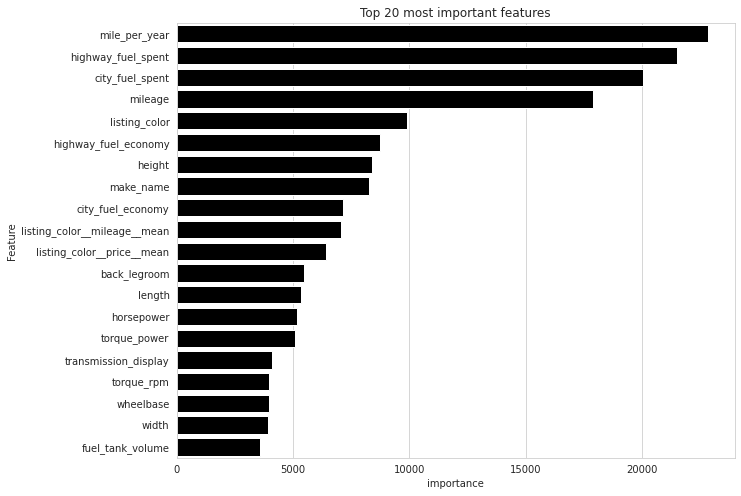

In [83]:
plt.figure(figsize=(10,8))
sns.barplot(x='importance',y='Feature',data=feature_importance_df.head(20),color='black')
plt.title('Top 20 most important features')

## Ensemble

In [92]:
df_train['lr'] = trn_pred_lr
df_test['lr'] = test_pred_lr
df_train['ridge'] = trn_pred_ridge
df_test['ridge'] = test_pred_ridge
df_train['lasso'] = trn_pred_lasso
df_test['lasso'] = test_pred_lasso
df_train['dt'] = trn_pred_dt
df_test['dt'] = test_pred_dt
df_train['lgb'] = trn_pred_lgb
df_test['lgb'] = test_pred_lgb
df_train['xgb'] = trn_pred_xgb
df_test['xgb'] = test_pred_xgb

In [94]:
scaler = MinMaxScaler().fit(df_train[['lr','ridge','lasso','dt','xgb','lgb','mileage']])

In [96]:
df_train[['lr','ridge','lasso','dt','xgb','lgb','mileage']] = scaler.transform(df_train[['lr','ridge','lasso','dt','xgb','lgb','mileage']])
df_test[['lr','ridge','lasso','dt','xgb','lgb','mileage']] = scaler.transform(df_test[['lr','ridge','lasso','dt','xgb','lgb','mileage']])

In [103]:
learner2 = Learner()
_ = learner2.train(df_train, target, ['lr','ridge','lasso','dt','xgb'], [], 5, 'Ridge', {}, mean_squared_error)

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

Ridge End of training, avg metric: 8184129.257221362


In [104]:
pred_ensemble = learner2.predict(df_test, ['lr','ridge','lasso','dt','xgb'], [], ['Ridge'])
mean_squared_error(df_test[target], pred_ensemble, squared=False)

Predicting: 1it [00:00,  2.62it/s]


2854.088494390054

In [105]:
with open(data_loc+'model2', 'wb') as h:
    pickle.dump(learner2, h)

In [106]:
with open(data_loc+'model2', 'rb') as h:
    learner2 = pickle.load(h)

In [107]:
pred_l = [test_pred_lr, test_pred_ridge, test_pred_lasso, test_pred_dt, test_pred_lgb, test_pred_xgb, pred_ensemble]
rmse_l = []
mse_l = []
mae_l = []
for pred in pred_l:
    rmse_l.append(mean_squared_error(df_test[target], pred, squared=False))
    mse_l.append(mean_squared_error(df_test[target], pred))
    mae_l.append(mean_absolute_error(df_test[target], pred))
metric_df = pd.DataFrame({'model':['lr','ridge','lasso','dt','lgb','xgb','ensemble'],'rmse':rmse_l,'mse':mse_l,'mae':mae_l})

In [108]:
metric_df

,model,rmse,mse,mae
0,lr,4179.112239,1.746498e+07,2938.365156
1,ridge,4179.112242,1.746498e+07,2938.363303
2,lasso,4180.510277,1.747667e+07,2938.706503
3,dt,3052.661944,9.318745e+06,2144.120327
4,lgb,2991.421925,8.948605e+06,2130.102748
5,xgb,2854.211530,8.146523e+06,2010.863878
6,ensemble,2854.088494,8.145821e+06,2010.643509


In [109]:
df_test['pred'] = pred_ensemble
df_test[['vin','pred']].to_csv(data_loc+'pred.csv',index=None)

## Appendix: Parameter estimation

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=54f72f1b15a57a042227cc14c0c9607dc67a80f6a11d744909fb987388845e70
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def estimate_lasso_param(alpha:float, max_iter:int):
    """
    Use Bayesian Optimization to estimate hyper-paramer of Ridge Regression
    """
    params = {
        'alpha':alpha,
        'max_iter':max_iter
    }

    model = Lasso(**params).fit(train_x.fillna(0), train_y)


    valid_pred = model.predict(valid_x.fillna(0))

    return -mean_squared_error(valid_y, valid_pred, squared=False)

In [ ]:
def estimate_ridge_param(alpha:float, max_iter:int):
    """
    Use Bayesian Optimization to estimate hyper-paramer of Ridge Regression
    """
    params = {
        'alpha':alpha,
        'max_iter':max_iter
    }

    trn_pred = learner.train(df_train, target, feats, [], 5, 'Ridge', params, mean_squared_error)

    return -mean_squared_error(df_train[target], trn_pred, squared=False)

In [ ]:
def estimate_dt_param(min_samples_split, min_samples_leaf, min_weight_fraction_leaf):
    """
    Use Bayesian Optimization to estimate hyper-paramer of Decision Tree
    """
    params = {
        # 'max_depth':int(max_depth),
        'min_samples_split':int(min_samples_split),
        'min_samples_leaf':int(min_samples_leaf),
        'min_weight_fraction_leaf':min_weight_fraction_leaf,
        # 'max_features':max_features,
        'random_state':2021
    }

    model = DecisionTreeRegressor(**params).fit(train_x.fillna(0), train_y)


    valid_pred = model.predict(valid_x.fillna(0))

    return -mean_squared_error(valid_y, valid_pred, squared=False)

In [ ]:
def estimate_xgb_param(gamma, max_depth, subsample, colsample_bytree, colsample_bylevel, eta):
    """
    Use Bayesian Optimization to estimate hyper-paramer of XGB
    """
    xgb_params = {
        'booster':'gbtree',
        'objective': 'reg:squarederror',
        'gamma':gamma,
        'max_depth':int(max_depth),
        'subsample':subsample,
        'colsample_bytree':colsample_bytree,
        'colsample_bylevel':colsample_bylevel,
        'eta': eta,
        'seed':2021,
        'silent':1,
        'tree_method':'gpu_hist',
        'gpu_id':0
    }

    trn_data = xgb.DMatrix(train_x, train_y)
    val_data = xgb.DMatrix(valid_x, valid_y)

    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    model = xgb.train(dtrain=trn_data, num_boost_round=10000, 
                    evals=watchlist, early_stopping_rounds=20,
                    verbose_eval=0, params=xgb_params)


    valid_pred = model.predict(xgb.DMatrix(valid_x), ntree_limit=model.best_ntree_limit)
    return -mean_squared_error(valid_y, valid_pred, squared=False)

In [ ]:
def estimate_lgb_param(bagging_fraction, max_depth, feature_fraction, min_data_in_leaf, num_leaves, lambda_l1, lambda_l2, lr):
    """
    Use Bayesian Optimization to estimate hyper-paramer of LGB
    """
    lgb_params = {
        'bagging_freq': 1,
        'bagging_fraction': bagging_fraction,
        'bagging_seed': 2021,
        'boost': 'gbdt',
        'feature_fraction': feature_fraction,
        'feature_fraction_seed': 2021,
        'learning_rate': lr,
        'max_depth': int(max_depth),  
        'metric':'l2_root',
        'min_data_in_leaf': int(min_data_in_leaf),
        'num_leaves': int(num_leaves),
        'objective': 'regression', 
        "lambda_l1": lambda_l1,
        'lambda_l2': lambda_l2,
        'device':'gpu',
        'verbose':-1
    }

    trn_data = lgb.Dataset(train_x, label=train_y)
    val_data = lgb.Dataset(valid_x, label=valid_y)
    model = lgb.train(
        lgb_params, 
        trn_data, 
        5000, 
        valid_sets = [trn_data, val_data], 
        verbose_eval=-1, 
        early_stopping_rounds = 20,
        categorical_feature=lgb_cat_feats,
        silent = True
    )
    valid_pred = model.predict(valid_x, num_iteration=model.best_iteration)
    return -mean_squared_error(valid_y, valid_pred, squared=False)

In [ ]:
pbounds = {
        'alpha':(0,30),
        'max_iter':(1000, 20000)
    }

optimizer = BayesianOptimization(
    f=estimate_ridge_param,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=5,
    n_iter=50,
)
print(optimizer.max)

In [ ]:
df_train = DataPreprocessor.create_folds(df_train, 5)
train_x = df_train[df_train['fold']!=0][feats]
train_y = df_train[df_train['fold']!=0][target]
valid_x = df_train[df_train['fold']==0][feats]
valid_y = df_train[df_train['fold']==0][target]

In [ ]:
pbounds = {
        'alpha':(0,30),
        'max_iter':(1000, 20000)
    }

optimizer = BayesianOptimization(
    f=estimate_lasso_param,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=5,
    n_iter=50,
)
print(optimizer.max)

In [ ]:
pbounds = {
    # 'max_depth':(5,100),
    'min_samples_split':(2, 200),
    'min_samples_leaf':(2, 200),
    'min_weight_fraction_leaf':(0, 0.5),
    # 'max_features':(0, 1)
}

optimizer = BayesianOptimization(
    f=estimate_dt_param,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=5,
    n_iter=50,
)
print(optimizer.max)

In [ ]:
pbounds = {
        'gamma':(0.,2),
        'max_depth':(5.,20.),
        'subsample':(0.,1.),
        'colsample_bytree':(0.,1.),
        'colsample_bylevel':(0.,1.),
        'eta': (0.005, 0.1)
    }

optimizer = BayesianOptimization(
    f=estimate_xgb_param,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(
    init_points=5,
    n_iter=50,
)
print(optimizer.max)

In [ ]:
df_train = DataPreprocessor.create_folds(df_train, 5)
train_x = df_train[df_train['fold']!=0][feats+lgb_cat_feats]
train_y = df_train[df_train['fold']!=0][target]
valid_x = df_train[df_train['fold']==0][feats+lgb_cat_feats]
valid_y = df_train[df_train['fold']==0][target]

In [ ]:
pbounds = {
    'bagging_fraction': (0.3,1),
    'feature_fraction': (0.2,1),
    'lr': (0.005,0.1),
    'max_depth': (5,20),
    'min_data_in_leaf': (1,50),
    'num_leaves': (64, 256),
    "lambda_l1": (0, 30),
    'lambda_l2': (0, 30)
}

optimizer = BayesianOptimization(
    f=estimate_lgb_param,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(
    init_points=5,
    n_iter=15,
)
print(optimizer.max)